# Experiment description
## Hypothesis: 
We can train sepp model at city aggregation using one-week data

## Method: 

Train model using one-week data (2017-01-01 to 2017-01-08) at city scope. Try different parameters to achieve model convergence:
- Default parameters.
- Change self._initial_time_bandwidth = 24 * 60 / 10 # minutes
- Change self._initial_space_bandwidth = 50.0
- Change time_cutoff
- Change space_cutoff

## Results:

- Successful training using time_cutoff set on: 30, 50, 70, 90, 120
- Less successful realizations for higher parameter values (e.g., 90 and 120)

In [1]:
%matplotlib inline
import pandas as pd
import pickle
import dateutil.parser
import pyproj
import open_cp
import open_cp.sepp as sepp
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import import_ipynb
import training_sepp_builtin

importing Jupyter notebook from training_sepp_builtin.ipynb
  Using cached https://github.com/QuantCrimAtLeeds/PredictCode/zipball/master
  Created wheel for opencp: filename=opencp-0.2.0-cp37-none-any.whl size=280058 sha256=e0cfc7b23aedcda046224194bb369515eccbc9afef9e0966c0949387842f81f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-zqgphsdh/wheels/9a/f6/1f/9ea8bd2ac044e7df5c432f658ba156f0cfc3540891a5bad62a
Successfully built opencp
  Using cached https://github.com/MatthewDaws/SEPP/zipball/master
  Created wheel for sepp: filename=sepp-0.9.0-cp37-none-any.whl size=37591 sha256=d4b0d670073d84a6c240e424e273de827abb25763099a3d1597fc8bd9a319d5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-gubtz0x8/wheels/1d/e6/94/444aa295403d7f0e2ffd698d822abc6a4427daa85f8c5cb0b0
Successfully built sepp


Failed to load 'descartes' package.


In [3]:
def selectDataPrediction(nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc = df[df["LOCALIDAD"]==nameLoc]
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_crime = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)
    
    return (points_crime,region)


In [4]:
def selectDataTraining(df,nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_train = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    return (points_train,timestamps,xcoords, ycoords)

In [5]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

def trainModel_parameters(df,nameLoc,dateIni,dateEnd,parameters,iterations=10):
    points_train,timestamps,xcoords, ycoords = selectDataTraining(df,nameLoc,dateIni,dateEnd)
    plt.scatter(xcoords, ycoords)
    print([timestamps])
    trainer = sepp.SEPPTrainer()
    trainer._initial_time_bandwidth = parameters['time_bw']
    trainer._initial_space_bandwidth = parameters['space_bw']
    trainer._time_cutoff = parameters['time_cutoff']
    trainer._space_cutoff = parameters['space_cutoff']
    print('time BW set on: ',trainer._initial_time_bandwidth)
    print('space BW set on: ',trainer._initial_space_bandwidth)
    print('time cutoff set on: ',trainer._time_cutoff)
    print('space cutoff set on: ',trainer._space_cutoff)
    print('Number of realizations: ',iterations)
    trainer.data = points_train    
    while True:  
        try:
            predictor = trainer.train()
            print("succesful training!")
            break
        except (RuntimeError, ValueError) as e:
            print(e)
            pass
        iterations = iterations - 1
        if iterations == 0:
            return "not succesfull training"
    return predictor 

In [6]:
def load_model(localidad, train_date):
    custom_path = path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+train_date+'.pkl'
    infile = open(custom_path,'rb')
    modelCrime = pickle.load(infile)
    infile.close()
    return modelCrime

In [7]:
def run_prediction(localidad,modelCrime,predict_time):
    points_crime,region = selectData(localidad,initial_date_prediction,final_date_prediction)
    modelCrime.data = points_crime 
    prediction = modelCrime.predict(predict_time)
    gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)
    hitrates = open_cp.evaluation.hit_rates(gridpred, points_crime, [0.01,0.1])
    return gridpred, hitrates

In [8]:
def plot_gridpred(localidad,predict_time,gridpred):
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
    ax.set_title("Predicción localidad: "+localidad+'; fecha: '+str(predict_time))
    fig.colorbar(m, ax=ax)

## Select data

In [9]:
path = '/u01/user8/Documents/Riñas'

In [10]:
df = pd.read_csv(path+'/datasets/verify_enrich_nuse_29112019.csv')

In [11]:
initial_date = '2017-01-01'
final_date = '2017-01-08'

## Training experiments

### Scenario 1: default parameters 

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
0 standard deviation: [2082.70620625    0.            0.        ]
0 standard deviation: [2081.89115108    0.            0.        ]
0 standard deviation: [2091.23662465    0.            0.        ]
Too small variance!
Too small variance!
0 standard deviation: [2088.53490434    0.            0.        ]
0 standard deviation: [2072.23554083    0.            0.        ]
0 standard deviation: [2074.2189138    0.           0.       ]
0 standard deviation: [2089.87258615    0.            0.        ]
0 standard deviation: [2085.21486577    0.            0.        ]
0 standard

KeyboardInterrupt: 

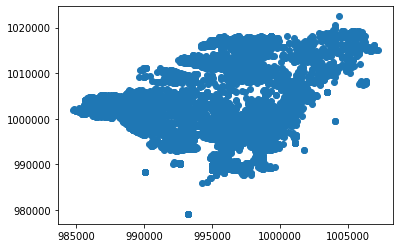

In [10]:
localidad = 'city'
city_predictor = training_sepp_builtin.trainModel_1(df,localidad,initial_date, final_date)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

### Result scenario 1: 
- Number of realizations: 25
- Average time elapsed for realization: 8 minutes 
- 0 standard deviation and small variance errors

### Scenario 2: sweep initial time BW
- Default: self._initial_time_bandwidth = 24 * 60 / 10 # minutes
- Set 1 of parameters: magnitude order variation over default parameter value [14, 144, 1440]
- Set 2 of parameters: upper variation over default value [288, 576, 864, 1152]

#### Parameter = 14

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  14
space BW set on:  50
0 standard deviation: [2079.01870484    0.            0.        ]
Too small variance!
0 standard deviation: [2089.68178509    0.            0.        ]
0 standard deviation: [2063.55453842    0.            0.        ]
Too small variance!
0 standard deviation: [2080.38773473    0.            0.        ]
Too small variance!
Too small variance!
0 standard deviation: [2080.09600079    0.            0.        ]


KeyboardInterrupt: 

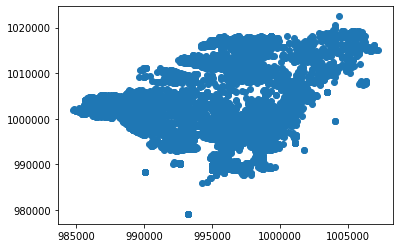

In [17]:
localidad = 'city'
parameters['time_bw'] = 14
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4 minutes
- 0 standard deviation and small variance errors

#### Parameter = 144

Experiment with this parameter was implemented on scenario 1 (parameters default values)
Results: 
- Number of realizations: 25
- Average time elapsed for realization: 8 minutes 
- 0 standard deviation and small variance errors

#### Parameter = 1440

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  1440
space BW set on:  50
0 standard deviation: [2079.74483713    0.            0.        ]
0 standard deviation: [2079.76764064    0.            0.        ]
0 standard deviation: [2086.97642204    0.            0.        ]
0 standard deviation: [2086.12797458    0.            0.        ]
0 standard deviation: [2084.89303775    0.            0.        ]
0 standard deviation: [2090.86089748    0.            0.        ]
0 standard deviation: [2079.25392247    0.            0.        ]
0 standard deviation: [2084.57131527    0.            0.        ]
0 st

KeyboardInterrupt: 

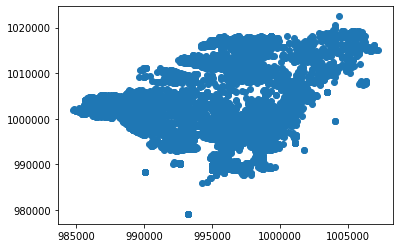

In [18]:
localidad = 'city'
parameters['time_bw'] = 1440
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 20
- Average time elapsed for realization: 3 min
- 0 standard deviation and small variance errors

#### Parameter = 14400

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  14400
space BW set on:  50
0 standard deviation: [2089.56581783    0.            0.        ]
0 standard deviation: [2078.78717369    0.            0.        ]
0 standard deviation: [2073.7531168    0.           0.       ]
Too small variance!
Too small variance!
0 standard deviation: [2079.60640315    0.            0.        ]
0 standard deviation: [2078.56825548    0.            0.        ]
0 standard deviation: [2080.43478729    0.            0.        ]
0 standard deviation: [2081.39915325    0.            0.        ]
0 standard deviation: [2076.6462

KeyboardInterrupt: 

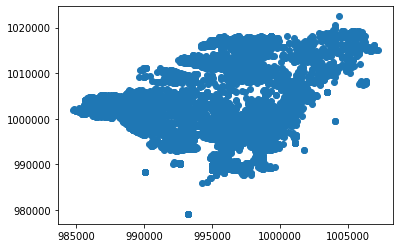

In [19]:
localidad = 'city'
parameters['time_bw'] = 14400
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 15
- Average time elapsed for realization: 3.6 min
- 0 standard deviation and small variance errors

### =================================================

#### Parameter = 288

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  288
space BW set on:  50
0 standard deviation: [2091.28179802    0.            0.        ]
0 standard deviation: [2077.57380131    0.            0.        ]
0 standard deviation: [2074.02330922    0.            0.        ]
0 standard deviation: [2081.2783744    0.           0.       ]
0 standard deviation: [2080.26408272    0.            0.        ]
0 standard deviation: [2084.64158527    0.            0.        ]
Too small variance!
0 standard deviation: [2079.33179788    0.            0.        ]
Too small variance!
0 standard deviation: [2089.080177

KeyboardInterrupt: 

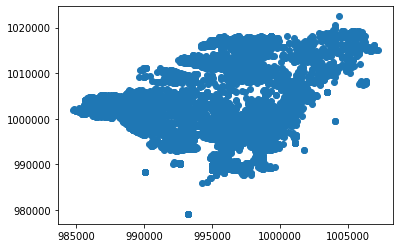

In [23]:
localidad = 'city'
parameters['time_bw'] = 288
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4 min
- 0 standard deviation and small variance errors

#### Parameter = 576

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  576
space BW set on:  50
0 standard deviation: [2078.21932949    0.            0.        ]
0 standard deviation: [2079.49695954    0.            0.        ]
0 standard deviation: [2090.24996749    0.            0.        ]
0 standard deviation: [2078.52363614    0.            0.        ]
0 standard deviation: [2082.19751066    0.            0.        ]
0 standard deviation: [2098.12588032    0.            0.        ]
Too small variance!
0 standard deviation: [2081.2592633    0.           0.       ]
0 standard deviation: [2080.65940434    0.            

KeyboardInterrupt: 

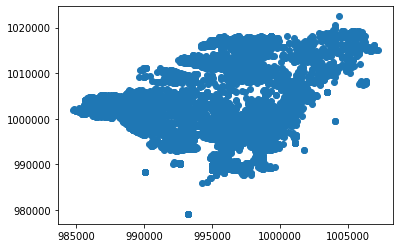

In [12]:
localidad = 'city'
parameters['time_bw'] = 576
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4.5 min
- 0 standard deviation and small variance errors

#### Parameter = 864

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  864
space BW set on:  50
0 standard deviation: [2085.47863852    0.            0.        ]
0 standard deviation: [2085.75673539    0.            0.        ]
0 standard deviation: [2086.82460868    0.            0.        ]
0 standard deviation: [2092.81680135    0.            0.        ]
0 standard deviation: [2088.98517781    0.            0.        ]
0 standard deviation: [2090.01739645    0.            0.        ]
0 standard deviation: [2092.13361184    0.            0.        ]
0 standard deviation: [2104.31572211    0.            0.        ]
0 sta

KeyboardInterrupt: 

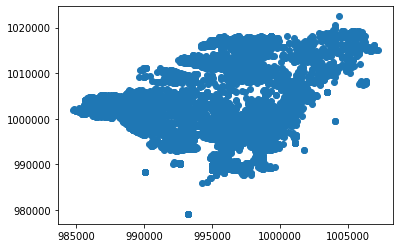

In [13]:
localidad = 'city'
parameters['time_bw'] = 864
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4 min
- 0 standard deviation and small variance errors

#### Parameter = 1152

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  1152
space BW set on:  50
0 standard deviation: [2080.29645946    0.            0.        ]
Too small variance!
Too small variance!
0 standard deviation: [2092.94434812    0.            0.        ]
0 standard deviation: [2094.18858026    0.            0.        ]
0 standard deviation: [2080.21226858    0.            0.        ]
0 standard deviation: [2091.19232254    0.            0.        ]
Too small variance!
0 standard deviation: [2085.2188691    0.           0.       ]
0 standard deviation: [2083.5579304    0.           0.       ]
0 standard devia

KeyboardInterrupt: 

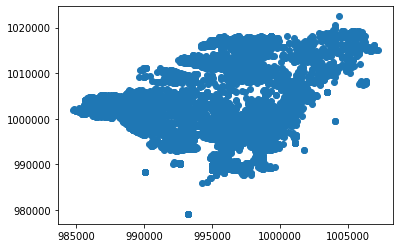

In [14]:
localidad = 'city'
parameters['time_bw'] = 1152
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 12
- Average time elapsed for realization: 3.6 min
- 0 standard deviation and small variance errors

### Scenario 3: sweep initial space BW
- Default: self._initial_space_bandwidth = 50
- Set 1 of parameters: magnitude order variation over default parameter value [5, 50, 500]
- Set 2 of parameters: upper variation over default value [70, 100, 200, 300]

#### Parameter = 5

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  5
0 standard deviation: [364.46055305   0.           0.        ]
0 standard deviation: [117.77321171   0.           0.        ]
0 standard deviation: [100.71402317   0.           0.        ]
0 standard deviation: [123.20107879   0.           0.        ]
0 standard deviation: [124.06909998   0.           0.        ]
0 standard deviation: [113.97046401   0.           0.        ]
0 standard deviation: [121.15206018   0.           0.        ]
0 standard deviation: [102.3281559   0.          0.       ]
Too small variance!
0 standard de

KeyboardInterrupt: 

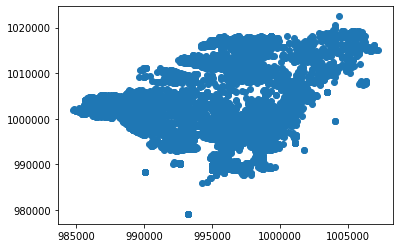

In [20]:
localidad = 'city'
parameters['space_bw'] = 5
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 20
- Average time elapsed for realization: 20 seg.
- 0 standard deviation and small variance errors

#### Parameter = 50

Experiment with this parameter was implemented on scenario 1 (parameters default values)
Results
- Number of realizations: 25
- Average time elapsed for realization: 8 minutes 
- 0 standard deviation and small variance errors

#### Parameter = 500

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  500
0 standard deviation: [2096.50382973    0.            0.        ]
Too small variance!
0 standard deviation: [2085.44361123    0.            0.        ]
0 standard deviation: [2072.4373338    0.           0.       ]
0 standard deviation: [2076.00705295    0.            0.        ]
0 standard deviation: [2092.6344176    0.           0.       ]
Too small variance!


KeyboardInterrupt: 

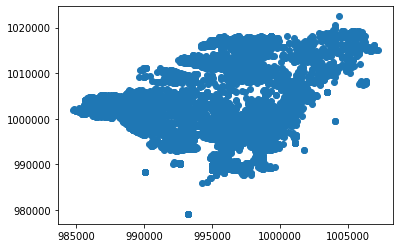

In [21]:
localidad = 'city'
parameters['space_bw'] = 500
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 7
- Average time elapsed for realization: 11 min
- 0 standard deviation and small variance errors

## =====================================================

#### Parameter = 70

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  70
0 standard deviation: [2075.17743014    0.            0.        ]
0 standard deviation: [2090.54165002    0.            0.        ]
Too small variance!
0 standard deviation: [2083.34876737    0.            0.        ]
0 standard deviation: [2072.09629614    0.            0.        ]
0 standard deviation: [2072.71260489    0.            0.        ]
0 standard deviation: [2084.69998492    0.            0.        ]


KeyboardInterrupt: 

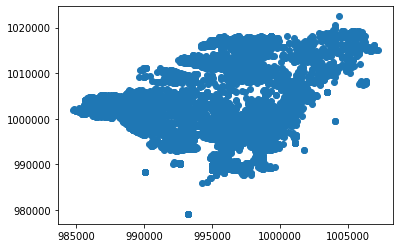

In [15]:
localidad = 'city'
parameters['space_bw'] = 70
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 7
- Average time elapsed for realization: 5 min
- 0 standard deviation and small variance errors

#### Parameter = 100

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  100
0 standard deviation: [2072.79298288    0.            0.        ]
0 standard deviation: [2084.36482748    0.            0.        ]
0 standard deviation: [2088.04665185    0.            0.        ]
0 standard deviation: [2081.25968851    0.            0.        ]
0 standard deviation: [2075.49029693    0.            0.        ]
0 standard deviation: [2075.28549163    0.            0.        ]
0 standard deviation: [2100.09346315    0.            0.        ]
0 standard deviation: [2073.54989411    0.            0.        ]
0 st

KeyboardInterrupt: 

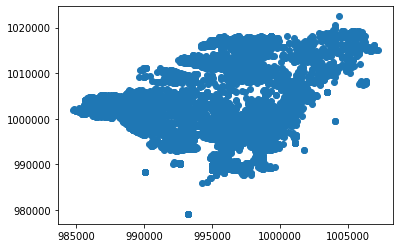

In [16]:
localidad = 'city'
parameters['space_bw'] = 100
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results:
- Number of realizations: 50
- Average time elapsed for realization: 5 min
- 0 standard deviation and small variance errors

#### Parameter = 200

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  200
0 standard deviation: [2084.35326001    0.            0.        ]
0 standard deviation: [2081.62668574    0.            0.        ]
0 standard deviation: [2088.41030367    0.            0.        ]
Too small variance!
0 standard deviation: [2082.54706507    0.            0.        ]
0 standard deviation: [2081.08583182    0.            0.        ]


KeyboardInterrupt: 

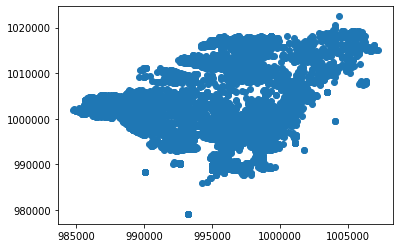

In [17]:
localidad = 'city'
parameters['space_bw'] = 200
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results:
- Number of realizations: 6
- Average time elapsed for realization: 8 min
- 0 standard deviation and small variance errors

#### Parameter = 300

In [ ]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  300
0 standard deviation: [2079.33194492    0.            0.        ]
0 standard deviation: [2089.68637067    0.            0.        ]
0 standard deviation: [2083.86088279    0.            0.        ]
0 standard deviation: [2097.78568447    0.            0.        ]
0 standard deviation: [2083.83181434    0.            0.        ]
0 standard deviation: [2078.12978284    0.            0.        ]
Too small variance!
Too small variance!
0 standard deviation: [2079.54198063    0.            0.        ]


KeyboardInterrupt: 

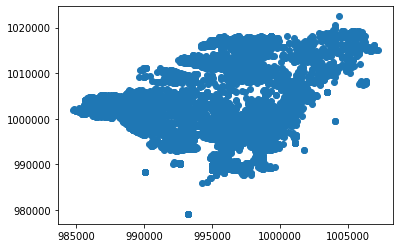

In [18]:
localidad = 'city'
parameters['space_bw'] = 300
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results:
- Number of realizations: 9
- Average time elapsed for realization: 7 min
- 0 standard deviation and small variance errors

### Scenario 4: sweep time cutoff
- Default: time_cutoff = 120 * 24 * 60 # minutes (i.e., 172800 min)
- Set 1 of parameters: magnitude order variation over default parameter value [17, 172, 1728, 17280, 1728000, 17280000]
- Set 2 of parameters: variation over lower parameters [20, 30, 50, 70, 90, 120, 150]

#### Parameter = 17

In [61]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  17
space cutoff set on:  500
Number of realizations:  20
Estimated only 4 triggered points, which is too few to allow KDE to function
Estimated only 2 triggered points, which is too few to allow KDE to function
Estimated only 4 triggered points, which is too few to allow KDE to function
Estimated only 3 triggered points, which is too few to allow KDE to function
Estimated only 2 triggered points, which is too few to allow KDE to function
Estimated only 2 triggered points, which is too few to allow KDE to fu

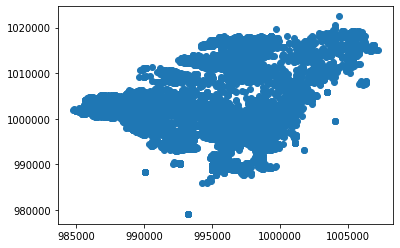

In [62]:
localidad = 'city'
parameters['time_cutoff'] = 17
iterations = 20
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 20
- Average time elapsed for realization: 1 min
- Few triggered points errors

#### Parameter = 172

In [63]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  172
space cutoff set on:  500
Number of realizations:  20
0 standard deviation: [45.35135945  0.          0.        ]
0 standard deviation: [45.96187598  0.          0.        ]
0 standard deviation: [45.15095105  0.          0.        ]


KeyboardInterrupt: 

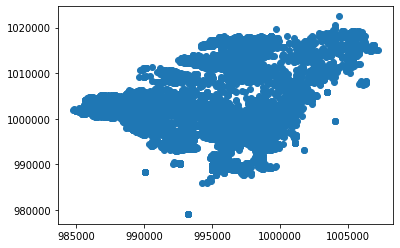

In [64]:
localidad = 'city'
parameters['time_cutoff'] = 172
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4 min
- 0 standard deviation errors

#### Parameter = 1728

In [35]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  1728
space cutoff set on:  500
Number of realizations:  10
0 standard deviation: [464.21455394   0.           0.        ]
0 standard deviation: [467.6438673   0.          0.       ]
0 standard deviation: [462.65471837   0.           0.        ]
0 standard deviation: [459.90040024   0.           0.        ]
Too small variance!
0 standard deviation: [462.57336016   0.           0.        ]
0 standard deviation: [466.67036456   0.           0.        ]
0 standard deviation: [466.71885465   0.           0.     

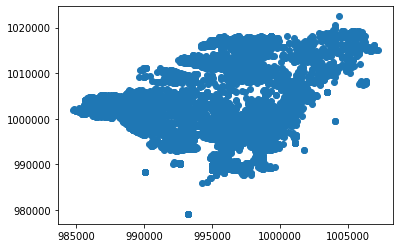

In [36]:
localidad = 'city'
parameters['time_cutoff'] = 1728
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 3 min
- 0 standard deviation and small variance errors

#### Parameter = 17280

In [37]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  17280
space cutoff set on:  500
Number of realizations:  10
0 standard deviation: [2091.52307941    0.            0.        ]
0 standard deviation: [2070.45617544    0.            0.        ]
0 standard deviation: [2073.57294755    0.            0.        ]
0 standard deviation: [2086.89246841    0.            0.        ]
0 standard deviation: [2080.84627256    0.            0.        ]
0 standard deviation: [2082.9861709    0.           0.       ]
0 standard deviation: [2076.46252747    0.            0.   

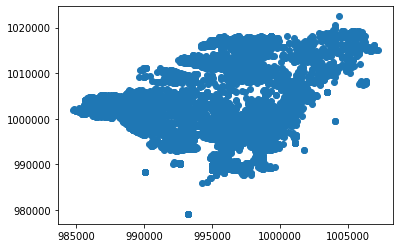

In [38]:
localidad = 'city'
parameters['time_cutoff'] = 17280
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4.5 min
- 0 standard deviation and small variance errors

#### Parameter = 1728000

In [39]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  1728000
space cutoff set on:  500
Number of realizations:  10
Too small variance!
Too small variance!
0 standard deviation: [2084.21424064    0.            0.        ]
0 standard deviation: [2072.11333342    0.            0.        ]
0 standard deviation: [2073.43342837    0.            0.        ]
0 standard deviation: [2094.52850771    0.            0.        ]
0 standard deviation: [2075.5806024    0.           0.       ]
0 standard deviation: [2091.40066903    0.            0.        ]
0 standard deviat

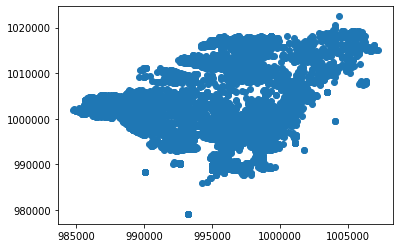

In [40]:
localidad = 'city'
parameters['time_cutoff'] = 1728000
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4.5 min
- 0 standard deviation and small variance errors

#### Parameter = 17280000

In [41]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  17280000
space cutoff set on:  500
Number of realizations:  10
0 standard deviation: [2068.29097623    0.            0.        ]
0 standard deviation: [2079.15031014    0.            0.        ]
0 standard deviation: [2086.25598061    0.            0.        ]
0 standard deviation: [2087.17574254    0.            0.        ]
0 standard deviation: [2073.2018698    0.           0.       ]
Too small variance!
Too small variance!
Too small variance!
0 standard deviation: [2083.68349077    0.            0.      

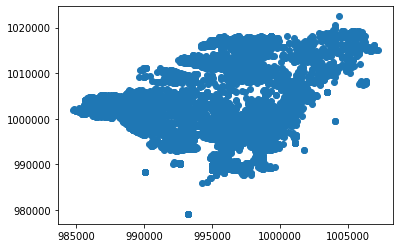

In [42]:
localidad = 'city'
parameters['time_cutoff'] = 17280000
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4.5 min
- 0 standard deviation and small variance errors

## =======================================================

#### Parameter = 20

In [65]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  20
space cutoff set on:  500
Number of realizations:  10
Estimated only 2 triggered points, which is too few to allow KDE to function
0 standard deviation: [0.         9.34125039 7.09855179]
Estimated only 9 triggered points, which is too few to allow KDE to function
Estimated only 6 triggered points, which is too few to allow KDE to function
Estimated only 7 triggered points, which is too few to allow KDE to function
0 standard deviation: [0.         9.04833029 5.0575788 ]
Estimated only 5 triggered points

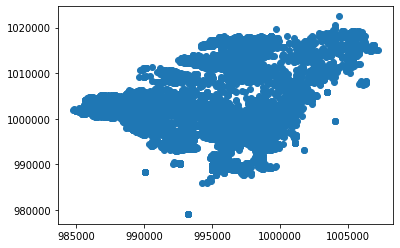

In [66]:
localidad = 'city'
parameters['time_cutoff'] = 20
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 3 min
- 0 standard deviation errors

#### Parameter = 30

In [65]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  30
space cutoff set on:  500
Number of realizations:  10
succesful training!


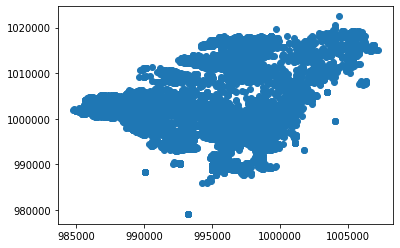

In [67]:
localidad = 'city'
parameters['time_cutoff'] = 30
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 10 min
- No errors

#### Parameter = 50

In [68]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  50
space cutoff set on:  500
Number of realizations:  10
succesful training!


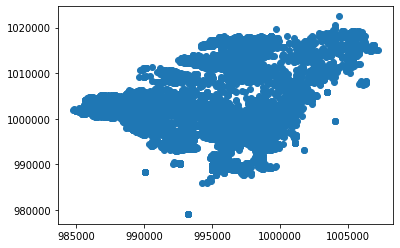

In [69]:
localidad = 'city'
parameters['time_cutoff'] = 50
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 10 min
- No errors

#### Parameter = 70

In [70]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  70
space cutoff set on:  500
Number of realizations:  10
succesful training!


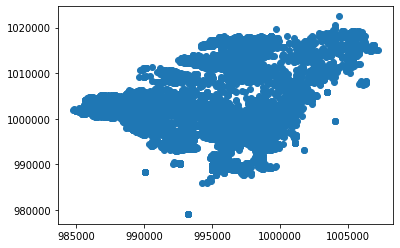

In [71]:
localidad = 'city'
parameters['time_cutoff'] = 70
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 10 min
- No errors

#### Parameter = 90

In [72]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  90
space cutoff set on:  500
Number of realizations:  10
0 standard deviation: [19.5721727  0.         0.       ]
0 standard deviation: [19.62732326  0.          0.        ]
0 standard deviation: [19.95097423  0.          0.        ]
succesful training!


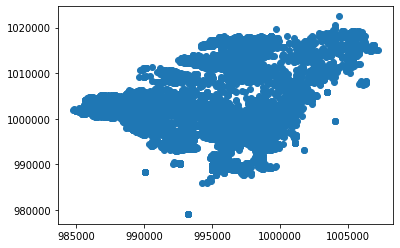

In [73]:
localidad = 'city'
parameters['time_cutoff'] = 90
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 4 (one successful)
- Average time elapsed for realization: 5 min
- 0 standard deviation errors

#### Parameter = 120

In [74]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  120
space cutoff set on:  500
Number of realizations:  10
0 standard deviation: [29.26118622  0.          0.        ]
0 standard deviation: [29.39831969  0.          0.        ]
0 standard deviation: [29.37095483  0.          0.        ]
0 standard deviation: [29.61636495  0.          0.        ]
0 standard deviation: [29.43336394  0.          0.        ]
0 standard deviation: [29.21408404  0.          0.        ]
0 standard deviation: [29.46345219  0.          0.        ]
0 standard deviation: [29.22931937

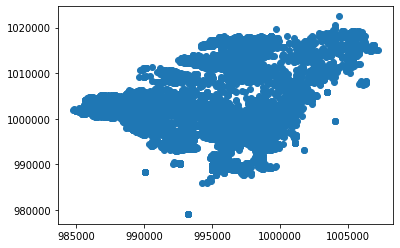

In [75]:
localidad = 'city'
parameters['time_cutoff'] = 120
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 9 (one successful)
- Average time elapsed for realization: 9 min
- 0 standard deviation errors

### Scenario 5: sweep space cutoff
- Default: time_cutoff = 500
- Set 1 of parameters: magnitude order variation over default parameter value [5, 50, 500, 5000]
- Set 2 of parameters: variation over lower parameters []

#### Parameter = 5

In [12]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  172800
space cutoff set on:  5
Number of realizations:  10
0 standard deviation: [137.48563451   0.           0.        ]
0 standard deviation: [172.97325103   0.           0.        ]
0 standard deviation: [154.06937368   0.           0.        ]
0 standard deviation: [143.85605869   0.           0.        ]
0 standard deviation: [159.79559527   0.           0.        ]
0 standard deviation: [169.08301755   0.           0.        ]
0 standard deviation: [157.19733937   0.           0.        ]
0 standard d

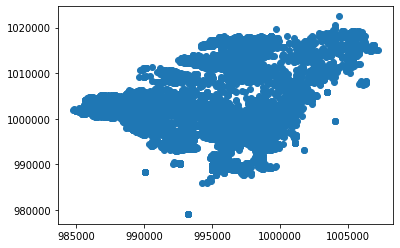

In [13]:
localidad = 'city'
parameters['space_cutoff'] = 5
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_space_cutoff_'+str(parameters['space_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 1 min
- 0 standard deviation error

#### Parameter = 50

In [14]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  172800
space cutoff set on:  50
Number of realizations:  10
0 standard deviation: [1950.85459019    0.            0.        ]
0 standard deviation: [1080.6868682    0.           0.       ]
Too small variance!
0 standard deviation: [1936.45398724    0.            0.        ]
Too small variance!
0 standard deviation: [2091.16914488    0.            0.        ]
0 standard deviation: [2193.29558995    0.            0.        ]
0 standard deviation: [1706.71258825    0.            0.        ]
Too small variance!

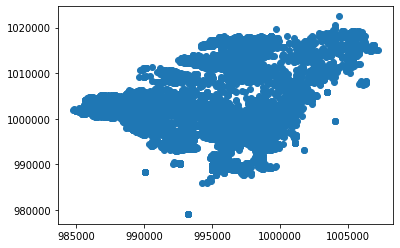

In [15]:
localidad = 'city'
parameters['space_cutoff'] = 50
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_space_cutoff_'+str(parameters['space_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 1 min
- 0 standard deviation and small variance errors

#### Parameter = 5000

In [14]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699538   2017-01-07 13:49:00
699539   2017-01-07 15:39:00
699541   2017-01-07 20:16:00
699548   2017-01-07 12:21:00
699549   2017-01-07 19:35:00
Name: FECHA_HORA_TS, Length: 7527, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  172800
space cutoff set on:  5000
Number of realizations:  10


KeyboardInterrupt: 

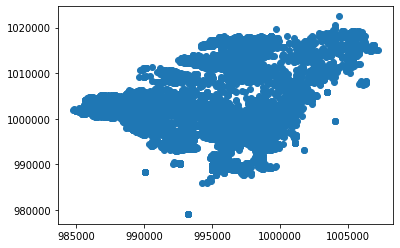

In [16]:
localidad = 'city'
parameters['space_cutoff'] = 5000
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_space_cutoff_'+str(parameters['space_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: > 1 hour
- 0 standard deviation